Predictions and simulations project

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
    
import matplotlib.pyplot as plt
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

In [2]:
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

<AxesSubplot:>

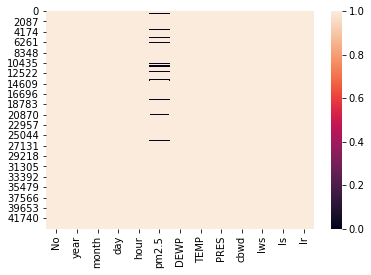

In [3]:
sns.heatmap(df.isna()==False)

In [4]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
df.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [6]:
df.rename({"pm2.5": "pm"}, axis=1, inplace=True)

<AxesSubplot:>

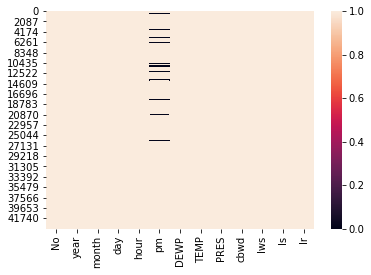

In [7]:
# co robimy z NaN'ami?
sns.heatmap(df.isna()==False)

In [8]:
datetime = df[['year', 'month', 'day', 'hour']]
datetime

,year,month,day,hour
0,2010,1,1,0
1,2010,1,1,1
2,2010,1,1,2
3,2010,1,1,3
4,2010,1,1,4
...,...,...,...,...
43819,2014,12,31,19
43820,2014,12,31,20
43821,2014,12,31,21
43822,2014,12,31,22


In [9]:
df['Datetime'] = pd.to_datetime(datetime)

In [10]:
df.head()

,No,year,month,day,hour,pm,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,Datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [11]:
# set up datetime column as index and delete nulls
df.index = df['Datetime']
del df['Datetime']
del df['No']
#df.dropna(inplace=True)

In [12]:
# filling missing values with an average PM for a corresponding hour
df["pm"] = df.groupby("hour")['pm'].transform(lambda x: x.fillna(x.mean()))


<AxesSubplot:ylabel='Datetime'>

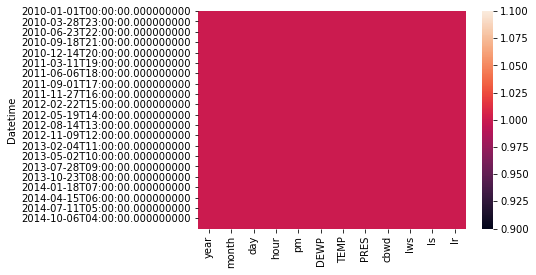

In [13]:
sns.heatmap(df.isna()==False)

In [14]:
df["pm"] = df["pm"].astype("int64")
df["TEMP"] = df["TEMP"].astype("int64")
df["PRES"] = df["PRES"].astype("int64")
df["Iws"] = df["Iws"].astype("int64")

In [15]:
%%markdown
## Data Exploration

## Data Exploration


([<matplotlib.axis.XTick at 0x16d5f1c9ca0>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sep'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

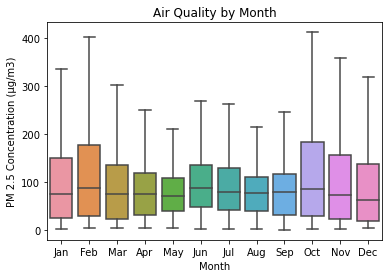

In [16]:
import calendar
# Plot PM 2.5 level by MONTH
plt.figure()
sns.boxplot(x="month", y="pm", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])

Text(0.5, 1.0, 'Air Quality by Day')

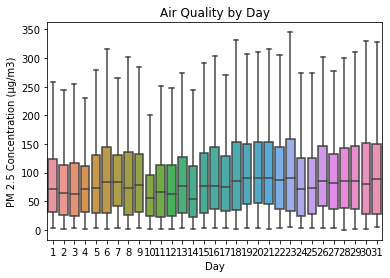

In [17]:
# Plot PM 2.5 level by DAY OF THE WEEK
plt.figure()
sns.boxplot(x="day", y="pm", data=df, showfliers=False)
plt.xlabel('Day')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day')
#plt.xticks(range(0,31), calendar.day_abbr[1:32])

<AxesSubplot:title={'center':'Second day PM'}, xlabel='Datetime'>

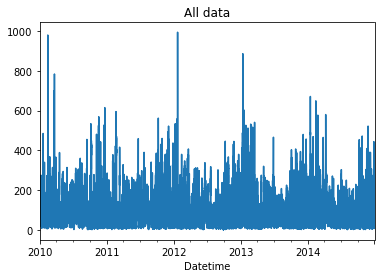

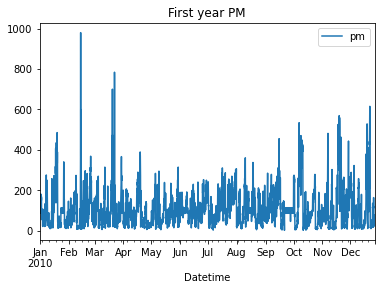

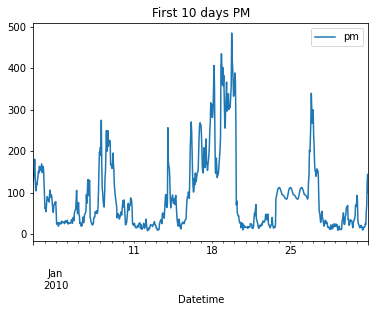

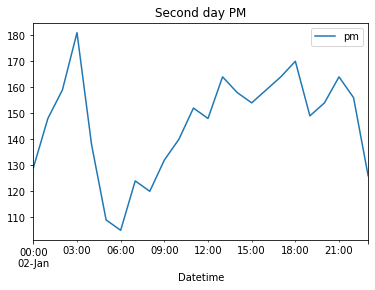

In [18]:
# plot PM variable
df['pm'].plot(title='All data')
df[0:24*30*12][['pm']].plot(title='First year PM')
df[24:24*31][['pm']].plot(title='First 10 days PM')
df[24:48][['pm']].plot(title='Second day PM')

<AxesSubplot:title={'center':'Average and Median PM readings for each hour'}, xlabel='hour'>

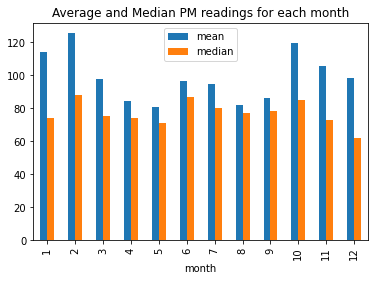

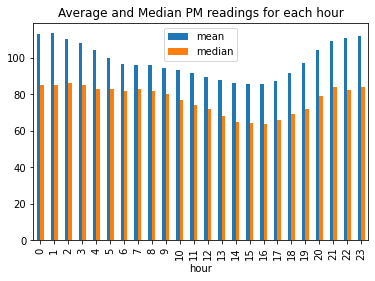

In [19]:
# plot the median and mean groups
df.groupby('month')['pm'].aggregate(['mean', 'median']).plot(kind="bar", title='Average and Median PM readings for each month')
df.groupby('hour')['pm'].aggregate(['mean', 'median']).plot(kind="bar", title='Average and Median PM readings for each hour')

In [20]:
%%markdown
## Feature Engineering

## Feature Engineering


In [21]:
# create a season variable with winter, spring, summer, fall instead of individual months

def season(month):
    if month in (4,5,6):
        return "spring"
    elif month in (7,8,9):
        return "summer"
    elif month in (10,11,12):
        return "fall"
    else:
        return "winter"
        
def season2(month):
    if month in (3, 4,5,6, 7, 8, 9):
        return "warm"
    elif month in (10, 11, 12 , 1, 2):
        return "cold"

df['season'] = df['month'].apply(season2)

In [22]:
# create a day time variable that aggregates hours into specific times of day

def day_time(hour):
    if hour in (20, 21, 22, 23, 0, 1, 2, 3, 4):
        return "night"
    elif hour in(5, 6, 7, 8, 9, 10, 11, 12):
        return "morning"
    else:
        return "afternoon"

df['day_time'] = df['hour'].apply(day_time)

In [23]:
# create a Trend variable to allow for time-series regression
df['Trend'] = np.arange(1, len(df) + 1)

# create a log pm2.5 variable
df['log_pm'] = np.log(df['pm']+1)

# create a one-hour lag variable 
df['log_lag_pm'] = df['log_pm'].shift(1)

# create a two-hour lag variable
df['log_lag_pm2'] = df['log_pm'].shift(2)

# create a 24-hour lag variable
df['log_lag_pm24'] = df['log_pm'].shift(24)

In [24]:
%%markdown
## Regression - In-the-Sample Prediction

## Regression - In-the-Sample Prediction


In [25]:
# set datetime frequency at hours
df = df.asfreq('h')

In [26]:
# split the dataset into train and test to allow for in and out of sample forecasts. Test dataset consists of one last month of observations
df_train = df[0:-365*24]
df_test = df[-365*24:]

In [27]:
%%markdown
### 1. First Model: All variables together

### 1. First Model: All variables together


In [28]:
# create model with formula
model_1 = sm.ols(formula="log_pm ~ Trend + C(year) + C(month) + C(hour) + DEWP + TEMP + PRES + C(cbwd) + Iws + Is + Ir", data=df)
results1 = model_1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     949.8
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:01   Log-Likelihood:                -45925.
No. Observations:               43824   AIC:                         9.195e+04
Df Residuals:                   43775   BIC:                         9.237e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          23.9166      0.716     33.418      0.000      22.514      25.319
C(year)[T.2011]    -1.8419      0.138    -13.385      0.000      -2.112      -1.572
C(year)[T.2012]    -3.7106      0.275    -13.492      0.000      -4.250      -3.172
C(year)[T.2013]    -5.3142      0.412    -12.890      0.000      -6.122      -4.506
C(year)[T.2014]    -7.1239      0.549    -12.966      0.000      -8.201      -6.047
C(month)[T.2]      -0.3530      0.020    -17.635      0.000      -0.392      -0.314
C(month)[T.3]      -0.8111      0.029    -28.120      0.000      -0.868      -0.755
C(month)[T.4]      -1.4392      0.041    -35.404      0.000      -1.519      -1.360
C(month)[T.5]      -2.1456      0.053    -40.482      0.000      -2.250      -2.042
C(month)[T.6]      -2.9216      0.064    -45.341      0.000      -3.048      -2.795
C(month)[T.7]      -3.3928      0.076    -44.867      0.000      -3.541      -3.245
C(month)[T.8]      -3.5253      0.086    -41.148      0.000      -3.693      -3.357
C(month)[T.9]      -3.2173      0.095    -33.878      0.000      -3.403      -3.031
C(month)[T.10]     -2.6824      0.105    -25.602      0.000      -2.888      -2.477
C(month)[T.11]     -2.1504      0.115    -18.641      0.000      -2.376      -1.924
C(month)[T.12]     -1.8120      0.127    -14.307      0.000      -2.060      -1.564
C(hour)[T.1]       -0.0388      0.023     -1.699      0.089      -0.084       0.006
C(hour)[T.2]       -0.0628      0.023     -2.745      0.006      -0.108      -0.018
C(hour)[T.3]       -0.0914      0.023     -3.989      0.000      -0.136      -0.047
C(hour)[T.4]       -0.1267      0.023     -5.518      0.000      -0.172      -0.082
C(hour)[T.5]       -0.1547      0.023     -6.724      0.000      -0.200      -0.110
C(hour)[T.6]       -0.1824      0.023     -7.924      0.000      -0.227      -0.137
C(hour)[T.7]       -0.1450      0.023     -6.315      0.000      -0.190      -0.100
C(hour)[T.8]       -0.0673      0.023     -2.933      0.003      -0.112      -0.022
C(hour)[T.9]        0.0108      0.023      0.468      0.640      -0.034       0.056
C(hour)[T.10]       0.0774      0.023      3.330      0.001       0.032       0.123
C(hour)[T.11]       0.1045      0.023      4.449      0.000       0.058       0.151
C(hour)[T.12]       0.1170      0.024      4.935      0.000       0.071       0.163
C(hour)[T.13]       0.1232      0.024      5.158      0.000       0.076       0.170
C(hour)[T.14]       0.1032      0.024      4.302      0.000       0.056       0.150
C(hour)[T.15]       0.0867      0.024      3.608      0.000       0.040       0.134
C(hour)[T.16]       0.0565      0.024      2.361      0.018       0.010       0.103
C(hour)[T.17]       0.0180      0.024      0.759      0.448      -0.028       0.064
C(hour)[T.18]      -0.0020      0.023     -0.084      0.933

<AxesSubplot:xlabel='Datetime'>

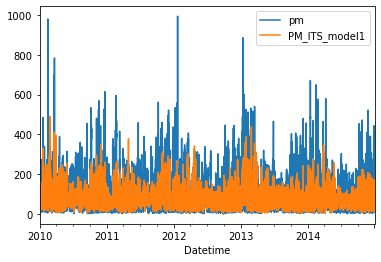

In [29]:
# create predictions and save to variables
df['PM_ITS_model1'] = np.exp(results1.predict(df))
# plot the predictions and actual values
dfplot = df.filter(['pm', 'PM_ITS_model1'])
dfplot[['pm', 'PM_ITS_model1']].plot()

In [30]:
%%markdown
### 2. Second Model: model with one-day lag, season and day_time categorical variables

### 2. Second Model: model with one-day lag, season and day_time categorical variables


In [31]:
# build a model with formula
model_2 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season) + C(day_time)", data=df)
results2 = model_2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 9.546e+04
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:03   Log-Likelihood:                -7309.4
No. Observations:               43823   AIC:                         1.463e+04
Df Residuals:                   43817   BIC:                         1.468e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1950      0.007     28.111      0.000       0.181       0.209
C(season)[T.warm]         -0.0002      0.003     -0.080      0.936      -0.006       0.005
C(day_time)[T.morning]    -0.0308      0.003     -8.871      0.000      -0.038      -0.024
C(day_time)[T.night]      -0.0013      0.003     -0.390      0.697      -0.008       0.005
Trend                  -1.602e-07   1.08e-07     -1.481      0.139   -3.72e-07    5.18e-08
log_lag_pm                 0.9568      0.001    686.150      0.000       0.954       0.960
==============================================================================
Omnibus:                    13014.534   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287533.110
Skew:                          -0.906   Prob(JB):                         0.00
Kurtosis:                      15.417   Cond. No.                     1.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='Datetime'>

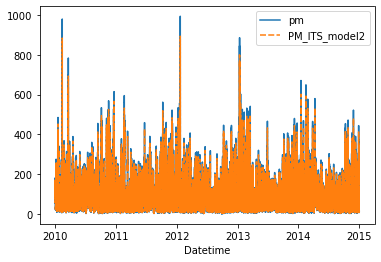

In [32]:
# create predictions and save to variable
df['PM_ITS_model2'] = np.exp(results2.predict(df))
# plot the predictions and actual data
dfplot = df.filter(['pm', 'PM_ITS_model2'])
sns.lineplot(data=dfplot)

<AxesSubplot:title={'center':'In-the-Sample Prediction'}, xlabel='Datetime'>

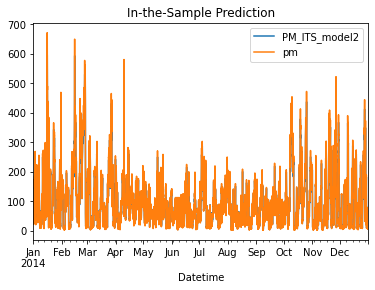

In [33]:
df[['PM_ITS_model2', 'pm']].tail(365*24).plot(title='In-the-Sample Prediction')

<AxesSubplot:title={'center':'In-the-Sample Prediction'}, xlabel='Datetime'>

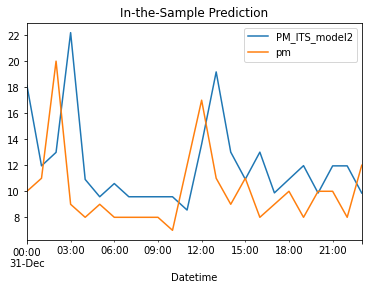

In [34]:
df[['PM_ITS_model2', 'pm']].tail(24).plot(title='In-the-Sample Prediction')

In [35]:
%%markdown
## Regression Out-of-Sample Prediction

## Regression Out-of-Sample Prediction


In [36]:
# build a model with formula
model_3 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season) + C(day_time)", data=df_train)
results3 = model_3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 7.449e+04
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:09   Log-Likelihood:                -5839.7
No. Observations:               35063   AIC:                         1.169e+04
Df Residuals:                   35057   BIC:                         1.174e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1980      0.008     25.381      0.000       0.183       0.213
C(season)[T.warm]          0.0015      0.003      0.480      0.631      -0.005       0.008
C(day_time)[T.morning]    -0.0282      0.004     -7.282      0.000      -0.036      -0.021
C(day_time)[T.night]      -0.0040      0.004     -1.046      0.296      -0.011       0.003
Trend                  -1.687e-07   1.51e-07     -1.116      0.264   -4.65e-07    1.27e-07
log_lag_pm                 0.9559      0.002    606.395      0.000       0.953       0.959
==============================================================================
Omnibus:                    10082.240   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           207867.847
Skew:                          -0.881   Prob(JB):                         0.00
Kurtosis:                      14.797   Cond. No.                     1.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
# create predictions and save to a variable
df['PM_OOS_model3'] = np.exp(results3.predict(df_test)) - 1

<AxesSubplot:title={'center':'Out-of-Sample Prediction'}, xlabel='Datetime'>

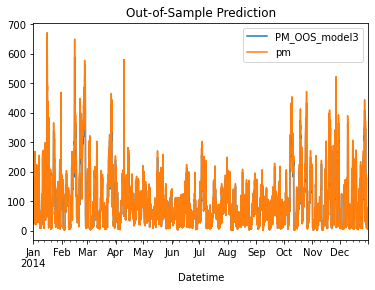

In [38]:
# plot predictions and actual values (whole time period)
df[['PM_OOS_model3', 'pm']].tail(365*24).plot(title="Out-of-Sample Prediction")

<AxesSubplot:title={'center':'In/Out-of-Sample Prediction'}, xlabel='Datetime'>

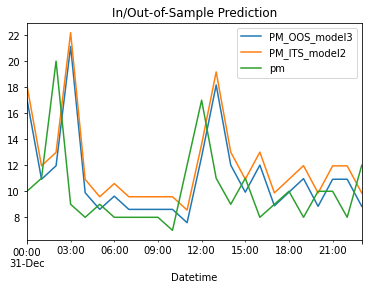

In [39]:
df[['PM_OOS_model3', 'PM_ITS_model2', 'pm']].tail(24).plot(title="In/Out-of-Sample Prediction")

In [40]:
%%markdown
## Regression: Including Independent Variables

## Regression: Including Independent Variables


In [41]:
# look at correlation between the independent variables and the independent one
df.corr()['pm']

year            -0.014249
month           -0.023650
day              0.080718
hour            -0.023692
pm               1.000000
DEWP             0.167437
TEMP            -0.089307
PRES            -0.046150
Iws             -0.240393
Is               0.019280
Ir              -0.049957
Trend           -0.017214
log_pm           0.863193
log_lag_pm       0.834347
log_lag_pm2      0.802253
log_lag_pm24     0.386735
PM_ITS_model1    0.627426
PM_ITS_model2    0.959364
PM_OOS_model3    0.968651
Name: pm, dtype: float64

In [42]:
%%markdown
### In-Sample

### In-Sample


In [43]:
model4 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season)+ C(day_time) + DEWP + Iws", data=df)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 6.872e+04
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:12   Log-Likelihood:                -7153.9
No. Observations:               43823   AIC:                         1.432e+04
Df Residuals:                   43815   BIC:                         1.439e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2796      0.008     33.207      0.000       0.263       0.296
C(season)[T.warm]         -0.0329      0.004     -8.935      0.000      -0.040      -0.026
C(day_time)[T.morning]    -0.0335      0.003     -9.675      0.000      -0.040      -0.027
C(day_time)[T.night]      -0.0017      0.003     -0.503      0.615      -0.008       0.005
Trend                  -4.202e-07   1.09e-07     -3.862      0.000   -6.33e-07   -2.07e-07
log_lag_pm                 0.9439      0.002    601.063      0.000       0.941       0.947
DEWP                       0.0016      0.000     11.753      0.000       0.001       0.002
Iws                       -0.0003   2.98e-05    -10.891      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    12844.577   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           284822.225
Skew:                          -0.887   Prob(JB):                         0.00
Kurtosis:                      15.363   Cond. No.                     1.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
%%markdown
### Independent variables do add some value to the model

### Independent variables do add some value to the model


<AxesSubplot:xlabel='Datetime'>

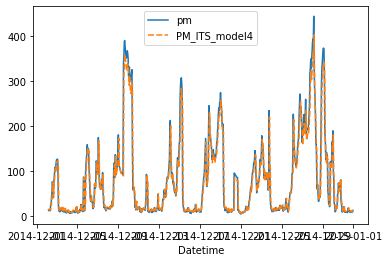

In [45]:
# create predictions and save to variable
df['PM_ITS_model4'] = np.exp(results4.predict(df))
# plot the predictions and actual data
dfplot = df.filter(['pm', 'PM_ITS_model4'])
sns.lineplot(data=dfplot.tail(716))

In [46]:
%%markdown
### Out of Sample

### Out of Sample


In [47]:
model45 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season)+ C(day_time) + DEWP + Iws", data=df_train)
results45 = model45.fit()
results45.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 5.364e+04
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:15   Log-Likelihood:                -5709.2
No. Observations:               35063   AIC:                         1.143e+04
Df Residuals:                   35055   BIC:                         1.150e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2873      0.010     30.111      0.000       0.269       0.306
C(season)[T.warm]         -0.0324      0.004     -7.864      0.000      -0.041      -0.024
C(day_time)[T.morning]    -0.0308      0.004     -7.972      0.000      -0.038      -0.023
C(day_time)[T.night]      -0.0041      0.004     -1.092      0.275      -0.012       0.003
Trend                  -5.099e-07   1.52e-07     -3.353      0.001   -8.08e-07   -2.12e-07
log_lag_pm                 0.9421      0.002    526.868      0.000       0.939       0.946
DEWP                       0.0017      0.000     11.082      0.000       0.001       0.002
Iws                       -0.0003   3.25e-05     -9.566      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     9915.281   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205163.967
Skew:                          -0.857   Prob(JB):                         0.00
Kurtosis:                      14.726   Cond. No.                     1.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='Datetime'>

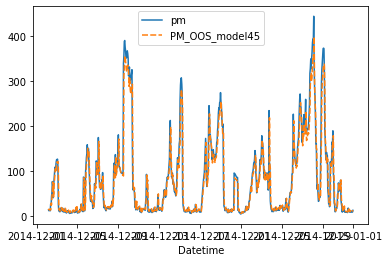

In [48]:
# create predictions and save to variable
df['PM_OOS_model45'] = np.exp(results45.predict(df_test))
# plot the predictions and actual data
dfplot = df.filter(['pm', 'PM_OOS_model45'])
sns.lineplot(data=dfplot.tail(716))

In [49]:
%%markdown
## Regression: with second lag added

## Regression: with second lag added


In [50]:
%%markdown
### In-the-sample

### In-the-sample


In [51]:
model_5 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + log_lag_pm2 + C(day_time) + DEWP + Iws", data=df)
results5 = model_5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 6.879e+04
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:19   Log-Likelihood:                -7130.9
No. Observations:               43822   AIC:                         1.428e+04
Df Residuals:                   43814   BIC:                         1.435e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2559      0.008     34.005      0.000       0.241       0.271
C(day_time)[T.morning]    -0.0319      0.003     -9.235      0.000      -0.039      -0.025
C(day_time)[T.night]      -0.0019      0.003     -0.571      0.568      -0.009       0.005
Trend                  -3.323e-07   1.08e-07     -3.072      0.002   -5.44e-07    -1.2e-07
log_lag_pm                 0.9984      0.005    208.865      0.000       0.989       1.008
log_lag_pm2               -0.0536      0.005    -11.252      0.000      -0.063      -0.044
DEWP                       0.0008      0.000      8.137      0.000       0.001       0.001
Iws                       -0.0003   2.98e-05    -11.465      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    12977.659   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           295026.169
Skew:                          -0.894   Prob(JB):                         0.00
Kurtosis:                      15.585   Cond. No.                     1.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='Datetime'>

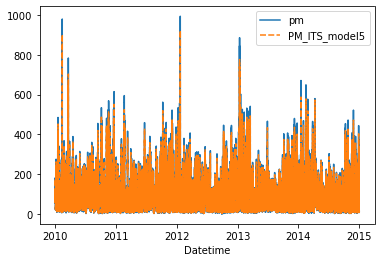

In [52]:
# create predictions and save to variable
df['PM_ITS_model5'] = np.exp(results5.predict(df))
# plot the predictions and actual data
dfplot = df.filter(['pm', 'PM_ITS_model5'])
sns.lineplot(data=dfplot)

<AxesSubplot:title={'center':'In-the-Sample Prediction'}, xlabel='Datetime'>

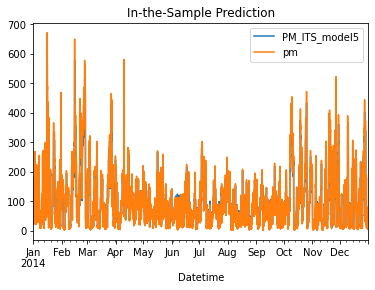

In [53]:
df[['PM_ITS_model5', 'pm']].tail(365*24).plot(title='In-the-Sample Prediction')

In [54]:
%%markdown
### Out-of-Sample

### Out-of-Sample


In [55]:
model_6 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + log_lag_pm2 + C(day_time)", data=df_train)
results6 = model_6.fit()
results6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 7.466e+04
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:28:26   Log-Likelihood:                -5802.1
No. Observations:               35062   AIC:                         1.162e+04
Df Residuals:                   35056   BIC:                         1.167e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2074      0.008     27.180      0.000       0.192       0.222
C(day_time)[T.morning]    -0.0273      0.004     -7.054      0.000      -0.035      -0.020
C(day_time)[T.night]      -0.0044      0.004     -1.156      0.248      -0.012       0.003
Trend                  -1.796e-07   1.51e-07     -1.191      0.234   -4.75e-07    1.16e-07
log_lag_pm                 1.0004      0.005    187.354      0.000       0.990       1.011
log_lag_pm2               -0.0465      0.005     -8.724      0.000      -0.057      -0.036
==============================================================================
Omnibus:                    10178.889   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           216006.600
Skew:                          -0.886   Prob(JB):                         0.00
Kurtosis:                      15.030   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
df['PM_OOS_model6'] = np.exp(results6.predict(df_test)) - 1

<AxesSubplot:title={'center':'In/Out-of-Sample Prediction'}, xlabel='Datetime'>

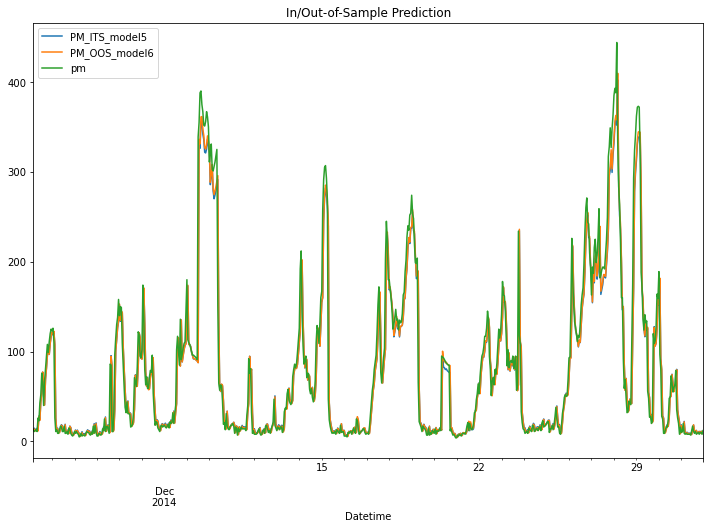

In [57]:
df[['PM_ITS_model5', 'PM_OOS_model6', 'pm']].tail(716).plot(title="In/Out-of-Sample Prediction", figsize=(12,8))

<AxesSubplot:title={'center':'In/Out-of-Sample Prediction'}, xlabel='Datetime'>

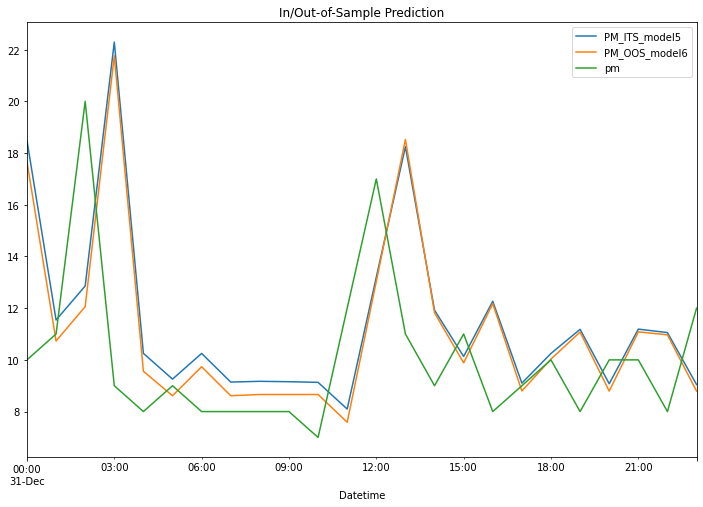

In [58]:
df[['PM_ITS_model5', 'PM_OOS_model6', 'pm']].tail(24).plot(title="In/Out-of-Sample Prediction", figsize=(12,8))

In [59]:
%%markdown
## Naive Forecast

## Naive Forecast


In [60]:
%%markdown
### Naive strategy: Mean

### Naive strategy: Mean


In [61]:
forecaster1 = NaiveForecaster(strategy='mean')
forecaster1.fit(df_train['pm'])
df['PM_Naive_Mean'] = forecaster1.predict(np.arange(1, len(df_test)))

<AxesSubplot:title={'center':'Naive Forecast, mean strategy'}, xlabel='Datetime'>

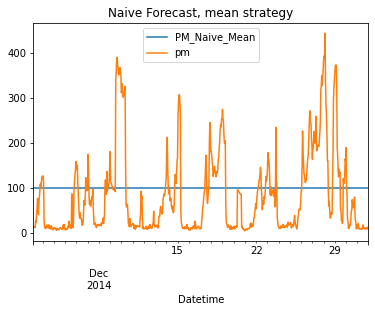

In [62]:
df[['PM_Naive_Mean', 'pm']].tail(716).plot(title='Naive Forecast, mean strategy')

In [63]:
forecaster2 = NaiveForecaster(strategy='last', sp=24)
forecaster2.fit(df_train['pm'])
df['PM_Naive_Last'] = forecaster2.predict(np.arange(1, len(df_test)))

<AxesSubplot:title={'center':'Naive Forecast, last strategy'}, xlabel='Datetime'>

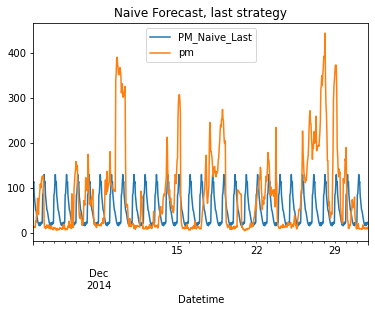

In [64]:
df[['PM_Naive_Last', 'pm']].tail(716).plot(title='Naive Forecast, last strategy')

In [ ]:
%%markdown 
## Error metrics: comparing models

## Error metrics: comparing models


In [65]:
cols_pred = ['PM_ITS_model1', 'PM_ITS_model2', 'PM_OOS_model3', 'PM_ITS_model4', 'PM_OOS_model45', 'PM_ITS_model5', 'PM_OOS_model6', 'PM_Naive_Mean', 'PM_Naive_Last', 'pm']
df_metrics = df[cols_pred].dropna()

mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
models, rmse, mae, mape = list(), list(), list(), list()
for col in cols_pred:
    models.append(col)
    rmse.append(np.sqrt(mean_squared_error(df_metrics['pm'].tail(716), df_metrics[col].tail(716))))
    mae.append(mean_absolute_error(df_metrics['pm'].tail(716), df_metrics[col].tail(716)))
    mape.append(mean_absolute_percentage_error(df_metrics['pm'].tail(716), df_metrics[col].tail(716)))




In [ ]:
metrics = pd.DataFrame({"model": models, "RMSE": rmse, "MAE": mae, "MAPE": mape})
metrics = metrics[:-2]
metrics

,model,RMSE,MAE,MAPE
0,PM_ITS_model1,72.913984,44.924373,0.948787
1,PM_ITS_model2,26.923217,14.455592,0.304353
2,PM_OOS_model3,27.101527,14.531027,0.285610
3,PM_ITS_model4,27.006112,14.689195,0.295320
4,PM_OOS_model45,27.213883,14.863379,0.294895
5,PM_ITS_model5,26.814870,14.390727,0.304177
6,PM_OOS_model6,26.981198,14.452071,0.285907
7,PM_Naive_Mean,94.506649,76.799058,3.825579
8,PM_Naive_Last,101.402814,69.871508,2.150386


In [ ]:
desc = ['Model with no-lag/All independent variables',
'Model with one-hour lag ITS',
'Model with one-hour lag OOS',
'Model with 1hr lag and 2 ind. var. OOS',
'Model with 1hr lag and 2 ind. var. ITS', 
'Model with 1hr and 2hr lag and 2 ind. var. OOS',
'Model with 1hr and 2hr lag and 2 ind. var. ITS',
'Naive model, mean strategy', 
'Naive model, last value in 24hr window'
]
metrics['desc'] = desc

In [ ]:
metrics[['desc', 'RMSE', 'MAE', 'MAPE']]

,desc,RMSE,MAE,MAPE
0,Model with no-lag/All independent variables,72.913984,44.924373,0.948787
1,Model with one-hour lag ITS,26.923217,14.455592,0.304353
2,Model with one-hour lag OOS,27.101527,14.531027,0.285610
3,Model with 1hr lag and 2 ind. var. OOS,27.006112,14.689195,0.295320
4,Model with 1hr lag and 2 ind. var. ITS,27.213883,14.863379,0.294895
5,Model with 1hr and 2hr lag and 2 ind. var. OOS,26.814870,14.390727,0.304177
6,Model with 1hr and 2hr lag and 2 ind. var. ITS,26.981198,14.452071,0.285907
7,"Naive model, mean strategy",94.506649,76.799058,3.825579
8,"Naive model, last value in 24hr window",101.402814,69.871508,2.150386


In [ ]:
%%markdown
## ARIMA model

## ARIMA model


In [63]:
from statsmodels.tsa.arima_model import ARIMA

dftest = df.filter(['pm', 'log_pm', 'log_lag_pm'])
dftest['d_d_log_pm'] = (dftest['log_lag_pm']).diff()
dftest = dftest.dropna()
dftest


,pm,log_pm,log_lag_pm,d_d_log_pm
Datetime,,,,
2010-01-01 02:00:00,110,4.709530,4.736198,0.000000
2010-01-01 03:00:00,108,4.691348,4.709530,-0.026668
2010-01-01 04:00:00,104,4.653960,4.691348,-0.018182
2010-01-01 05:00:00,100,4.615121,4.653960,-0.037388
2010-01-01 06:00:00,96,4.574711,4.615121,-0.038840
...,...,...,...,...
2014-12-31 19:00:00,8,2.197225,2.397895,0.095310
2014-12-31 20:00:00,10,2.397895,2.197225,-0.200671
2014-12-31 21:00:00,10,2.397895,2.397895,0.200671


In [66]:
arima_model = ARIMA(dftest.d_d_log_pm, order=(1,0,2))
model  = arima_model.fit(disp=0)
print(model.summary())

e:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
e:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

                              ARMA Model Results                              
Dep. Variable:             d_d_log_pm   No. Observations:                43822
Model:                     ARMA(1, 2)   Log Likelihood               -7311.585
Method:                       css-mle   S.D. of innovations              0.286
Date:                Wed, 15 Jun 2022   AIC                          14633.169
Time:                        14:27:49   BIC                          14676.609
Sample:                    01-01-2010   HQIC                         14646.861
                         - 12-31-2014                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5.025e-06   1.21e-05     -0.416      0.677   -2.87e-05    1.86e-05
ar.L1.d_d_log_pm     0.9525      0.001    867.996      0.000       0.950       0.955
ma.L1.d_d_log_pm    -0.9470 

In [67]:
print(model.aic)

14633.169388338705


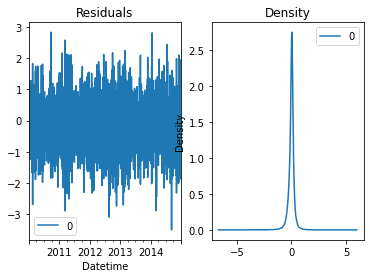

In [68]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

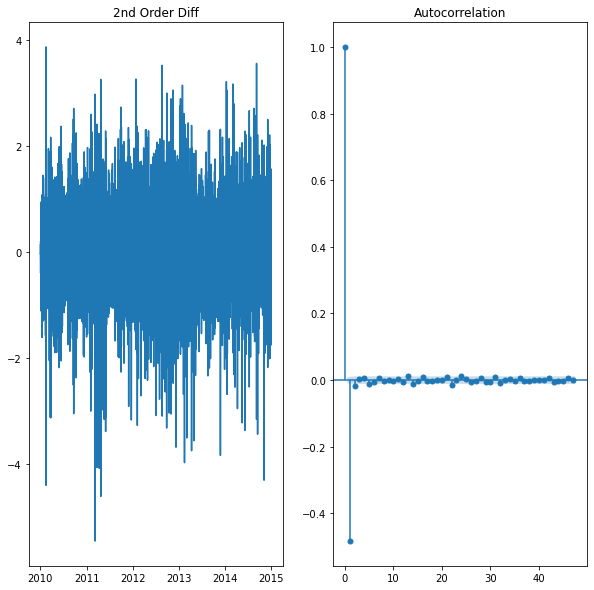

In [73]:
from statsmodels.graphics.tsaplots import plot_acf
f = plt.figure(figsize= (10, 10))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Diff')
ax1.plot(df.log_pm.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df.log_pm.diff().diff().dropna(), ax = ax2)
plt.show()

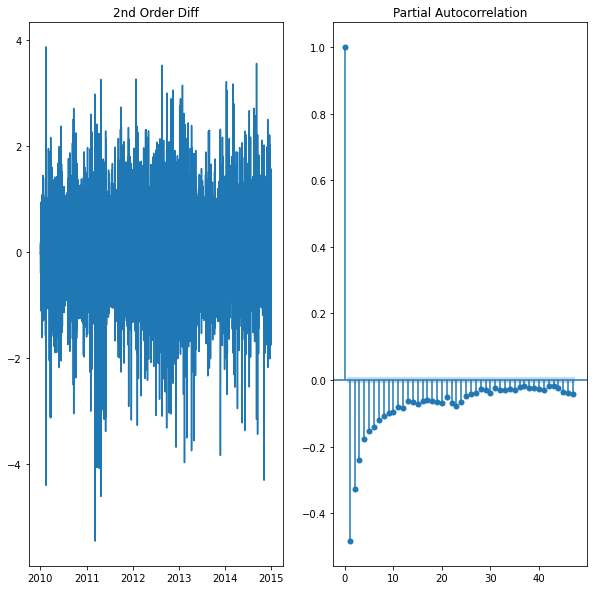

In [71]:
import statsmodels.api as sm

f = plt.figure(figsize= (10, 10))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Diff')
ax1.plot(df.log_pm.diff().diff())

ax2 = f.add_subplot(122)
sm.graphics.tsa.plot_pacf(df.log_pm.diff().diff().dropna(), ax = ax2)
plt.show()

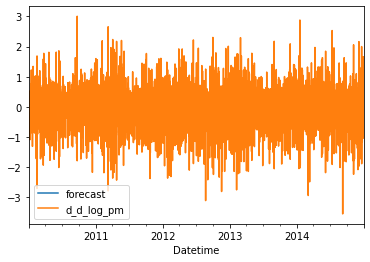

In [69]:
model.plot_predict(dynamic=False)
plt.show()

In [66]:
%%markdown
## Skit forecast -> Naive and SARIMAX (we have tried...)

## Skit forecast -> Naive and SARIMAX (we have tried...)


In [67]:
%matplotlib inline

In [68]:
fh = np.arange(1, 92*24)
forecaster = NaiveForecaster(strategy="mean", sp=7200)
forecaster.fit(df['pm'])
df.pm_pred = forecaster.predict(fh)

<ipython-input-68-00074e2e08bb>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.pm_pred = forecaster.predict(fh)


In [69]:
df_train_slc = pd.DataFrame(df.pm.tail(183*24))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='pm'>)

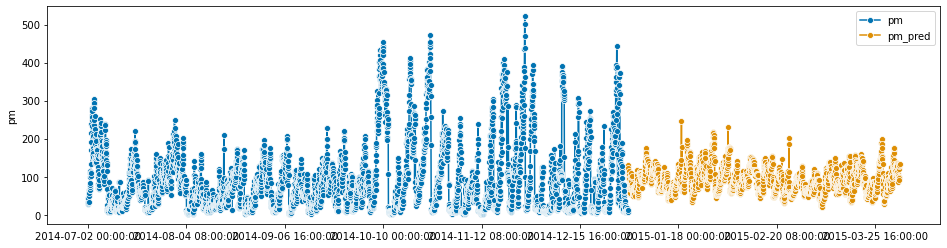

In [70]:
plot_series(df_train_slc.pm, df.pm_pred, labels=["pm", "pm_pred"])

SARIMAX


In [71]:
from sktime.forecasting.sarimax import SARIMAX

In [72]:
forecaster = SARIMAX(order=(1, 0, 2), trend="ct", seasonal_order=(1, 0, 2, 6))
forecaster.fit(df['pm'])

SARIMAX(order=(1, 0, 2), seasonal_order=(1, 0, 2, 6), trend='ct')

In [73]:
df.pm_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='pm'>)

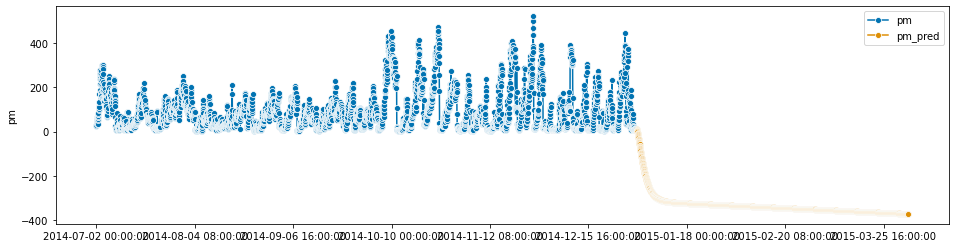

In [74]:
plot_series(df_train_slc.pm, df.pm_pred, labels=["pm", "pm_pred"])